In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline


Sampling quadratures of non-Gaussian states using the bosonic backend
=====================================================================

<div class="alert alert-info"><h4>Note</h4><p>This tutorial is second in a series on the ``bosonic`` backend. For an introduction
   to the backend, see :doc:`part 1 </demos/run_intro_bosonic>`. Once finished this tutorial,
   check out :doc:`part 3 </demos/run_GKP_bosonic>` for a deep dive into using the ``bosonic``
   backend to simulate qubits encoded in photonic modes. These tutorials accompany
   our research paper [[#bourassa2021]_].</p></div>

In a previous :doc:`tutorial </demos/run_intro_bosonic>` we introduced
the ``bosonic`` backend, the fourth and latest software backend of Strawberry Fields.
In this tutorial we continue investigating some of its functionality
by exploring how to sample quadrature (homodyne) measurements in non-Gaussian
states. While these simulations could be done in the ``fock`` backend, it is a lot
more convenient to use the new backend, since simulations in the ``fock`` backend need to
remain under an energy ``cutoff``.

We first return to our old friend, the cat state, and see how it looks when projected
(measured) along different quadratures of phase space.
Then we investigate a useful class of non-Gaussian states known as grid or GKP states.
These states are named after `Daniel Gottesman <https://en.wikipedia.org/wiki/Daniel_Gottesman>`_ ,
`Alexei Kitaev <https://en.wikipedia.org/wiki/Alexei_Kitaev>`_ and
`John Preskill <https://en.wikipedia.org/wiki/John_Preskill>`_
who introduced them in a seminal paper in 2001 [[#gottesman2001]_].


Cat quadratures
---------------
In a previous tutorial we investigated the Wigner function of the cat
state. Now, we will explore the distributions of its quadratures.
The distributions of the position $q$ and momentum $p$
quadratures can be obtained by integrating the Wigner function:

\begin{align}\text{Pr}(q=x) = \int_{-\infty}^\infty dp~ W(x,p), \\
    \text{Pr}(p=y) = \int_{-\infty}^\infty dq~ W(q,y).\end{align}

Note that even though the Wigner function can be negative (as it is a `quasiprobability distribution <https://en.wikipedia.org/wiki/Quasiprobability_distribution>`_), the quadrature
distributions $\text{Pr}(q=x)$ and $\text{Pr}(p=y)$ are proper
probability distributions, i.e., they are non-negative and their integrals
equal unity.

We will use Strawberry Fields to investigate how these distributions look
for a cat state.



In [2]:
# We do the usual imports
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

# Create cat state
prog_cat = sf.Program(1)

with prog_cat.context as q:
    sf.ops.Catstate(a=2) | q

eng = sf.Engine("bosonic")
cat = eng.run(prog_cat).state

Strawberry Fields provides handy functions for accessing the quadrature
distributions. These can retrieved using the ``marginal`` method of the
``state`` object:



In [3]:
# Calculate the quadrature distributions
scale = np.sqrt(sf.hbar)
quad_axis= np.linspace(-6, 6, 1000) * scale
cat_prob_x = cat.marginal(0, quad_axis)  # This is the q quadrature
cat_prob_p = cat.marginal(0, quad_axis, phi=np.pi / 2)  # This is the p quadrature

We can also use Strawberry Fields to generate samples of a given quadrature.
In this case, we do it for the $q$ quadrature:



In [4]:
# Run the program again, collecting q samples this time
shots = 2000  # Number of samples
prog_cat_x = sf.Program(1)

with prog_cat_x.context as q:
    sf.ops.Catstate(a=2) | q
    sf.ops.MeasureX | q

eng = sf.Engine("bosonic")
cat_samples_x = eng.run(prog_cat_x, shots=shots).samples[:, 0]

We can also sample the $p$ quadrature:



In [5]:
# Run the program again, collecting p samples this time
prog_cat_p = sf.Program(1)

with prog_cat_p.context as q:
    sf.ops.Catstate(a=2) | q
    sf.ops.MeasureP | q

eng = sf.Engine("bosonic")
cat_samples_p = eng.run(prog_cat_p, shots=shots).samples[:, 0]

We can verify that the samples distribute according to the expected distribution:



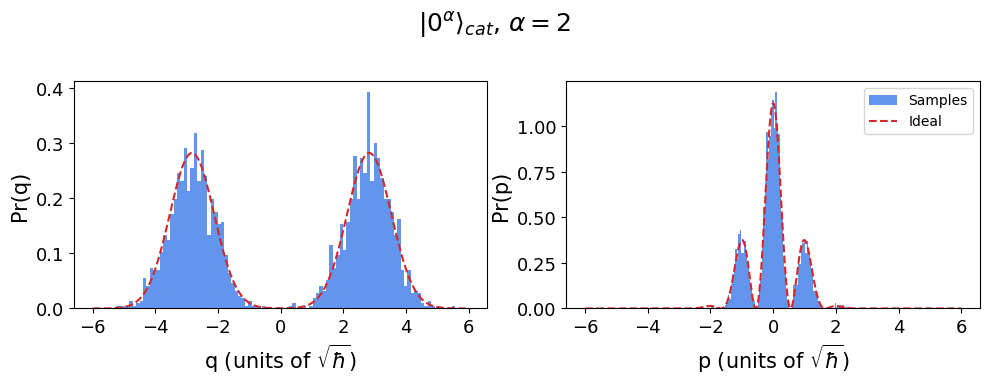

In [6]:
# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(r"$|0^{\alpha}\rangle_{cat}$, $\alpha=2$", fontsize=18)

axs[0].hist(cat_samples_x / scale, bins=100, density=True, label="Samples", color="cornflowerblue")
axs[0].plot(quad_axis/ scale, cat_prob_x * scale, "--", label="Ideal", color="tab:red")
axs[0].set_xlabel(r"q (units of $\sqrt{\hbar}$)", fontsize=15)
axs[0].set_ylabel("Pr(q)", fontsize=15)

axs[1].hist(cat_samples_p / scale, bins=100, density=True, label="Samples", color="cornflowerblue")
axs[1].plot(quad_axis/ scale, cat_prob_p * scale, "--", label="Ideal", color="tab:red")
axs[1].set_xlabel(r"p (units of $\sqrt{\hbar}$)", fontsize=15)
axs[1].set_ylabel("Pr(p)", fontsize=15)

axs[1].legend()
axs[0].tick_params(labelsize=13)
axs[1].tick_params(labelsize=13)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

As we can see, we obtain a positive-valued probability distribution.
The two lobes arising from the coherent states superposed in the cat state
are clearly visible in $q$ distribution.




GKP quadratures
---------------
As mentioned before, the ``bosonic`` backend can easily handle a number
of nonclassical states of light. A particularly useful family of states
are the so-called GKP or grid states. In the same way that cat states
are linear superpositions of two coherent states, GKP states can be understood
as superpositions of multiple squeezed states.
We can generate a GKP state and plot its Wigner function using Strawberry Fields in
the same way we did for cat states.




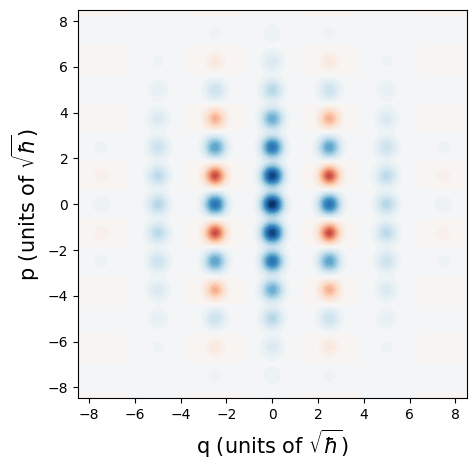

In [7]:
# Create GKP state
epsilon = 0.1
prog_gkp = sf.Program(1)
with prog_gkp.context as q:
    sf.ops.GKP(epsilon=epsilon) | q
eng = sf.Engine("bosonic")
gkp = eng.run(prog_gkp).state

Wgkp = gkp.wigner(mode=0, xvec=quad_axis, pvec=quad_axis)
scale = np.max(Wgkp.real)
nrm = mpl.colors.Normalize(-scale, scale)
plt.axes().set_aspect("equal")
plt.contourf(quad_axis, quad_axis, Wgkp, 60, cmap=cm.RdBu, norm=nrm)
plt.xlabel(r"q (units of $\sqrt{\hbar}$)", fontsize=15)
plt.ylabel(r"p (units of $\sqrt{\hbar}$)", fontsize=15)
plt.tight_layout()
plt.show()

We see that GKP states in phase space are made of multiple narrow peaks of
alternating signs.
After getting an idea of how a GKP state looks in phase-space we can now
turn our attention to understanding its quadrature distribution.



In [8]:
# As before, we can directly calculate the expected quadrature distributions
scale = np.sqrt(sf.hbar * np.pi)
quad_axis= np.linspace(-6, 6, 1000) * scale
gkp_prob_x = gkp.marginal(0, quad_axis)
gkp_prob_p = gkp.marginal(0, quad_axis, phi=np.pi / 2)

Like before, we can collect samples of the quadratures to
simulate the state being probed with homodyne measurements:



In [9]:
# Run the program again, collecting q samples this time
prog_gkp_x = sf.Program(1)
with prog_gkp_x.context as q:
    sf.ops.GKP(epsilon=0.1) | q
    sf.ops.MeasureX | q
eng = sf.Engine("bosonic")
gkp_samples_x = eng.run(prog_gkp_x, shots=shots).samples[:, 0]

# Run the program again, collecting p samples this time
prog_gkp_p = sf.Program(1)
with prog_gkp_p.context as q:
    sf.ops.GKP(epsilon=0.1) | q
    sf.ops.MeasureP | q
eng = sf.Engine("bosonic")
gkp_samples_p = eng.run(prog_gkp_p, shots=shots).samples[:, 0]

and can compare the results:



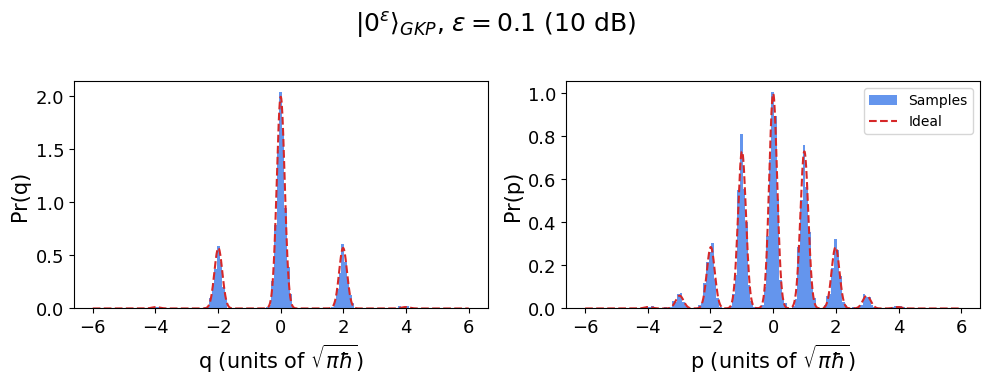

In [10]:
# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(r"$|0^\epsilon\rangle_{GKP}$, $\epsilon=0.1$ (10 dB)", fontsize=18)

axs[0].hist(gkp_samples_x / scale, bins=100, density=True, label="Samples", color="cornflowerblue")
axs[0].plot(quad_axis/ scale, gkp_prob_x * scale, "--", label="Ideal", color="tab:red")
axs[0].set_xlabel(r"q (units of $\sqrt{\pi\hbar}$)", fontsize=15)
axs[0].set_ylabel("Pr(q)", fontsize=15)

axs[1].hist(gkp_samples_p / scale, bins=100, density=True, label="Samples", color="cornflowerblue")
axs[1].plot(quad_axis/ scale, gkp_prob_p * scale, "--", label="Ideal", color="tab:red")
axs[1].set_xlabel(r"p (units of $\sqrt{\pi\hbar}$)", fontsize=15)
axs[1].set_ylabel("Pr(p)", fontsize=15)

axs[1].legend()
axs[0].tick_params(labelsize=13)
axs[1].tick_params(labelsize=13)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The comb of peaks are clearly visible in both the quadratures, as are
visible the Gaussian spread of the individual peaks and the Gaussian
envelope on the height of all the peaks.



Conclusion and Outlook
----------------------
In this tutorial we have explored the sampling functionality
of the ``bosonic`` backend by investigating the quadrature distributions
of both cat and GKP states. For advanced readers, we encourage you to
read :doc:`part 3 </demos/run_GKP_bosonic>` to take a dive
into how GKP states can be used to encode a qubit in a photonic mode.



References
----------

.. [#bourassa2021]

    J. Eli Bourassa, Nicolás Quesada, Ilan Tzitrin, Antal Száva, Theodor Isacsson,
    Josh Izaac, Krishna Kumar Sabapathy, Guillaume Dauphinais, and Ish Dhand.
    Fast simulation of bosonic qubits via Gaussian functions in phase space.
    `arXiv:2103.05530 <https://arxiv.org/abs/2103.05530>`_, 2021.

.. [#gottesman2001]

    Daniel Gottesman, Alexei Kitaev, and John Preskill. Encoding a qubit in an oscillator.
    doi:10.1103/PhysRevA.64.012310.

